## Serious Work Injuries: United States 2015 to 2017 
_By Nick Brooks, February 2018_

Follow me through this analysis. Not for the faint of heart. 

# Tables of Content:

**1. [What does this Dataset consist of?](#Consist)** <br>
**2. [Dataset Fixing](#Fix)** <br>
**3. [Univariate Anlysis](#Univariate)** <br>
**3. [Multivariate Distribution](#Multivariate)** <br>

In [1]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *

# Warnings
# import warnings
# warnings.filterwarnings('ignore')


# Extra
from os import path


In [242]:
path= r"/Users/nicapotato/Google Drive/Learning/Jupyter/Data/injured-workers" # MAC
#path= r"C:\Users\Nicol\Google Drive\Learning\Jupyter\Data\injured-workers" # Windows
os.chdir(path)

#df = pd.read_csv(open(os.path.join(path, "severeinjury.csv"), "r",encoding="latin-1"))
df = pd.read_csv("severeinjury.csv", encoding="latin-1")

## What does this Dataset consist of?

In [243]:
# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    mode = df[x].mode().iloc[0]
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum(),mode, df[x][df[x]==mode].count(),df[x].dtypes])

print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T

Dataframe Dimension: 21578 Rows, 26 Columns


Column,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title
Unique,21573,21578,790,18004,20261,1793,4643,56,7976,2150,...,149,149,118,118,306,307,903,903,629,629
Missing,0,0,0,0,10,19717,9,0,11,91,...,0,0,0,0,0,0,0,0,15766,15766
Mode,2015010015,892735,9/2/2015,U.S. Postal Service,Unknown,Suite 100,HOUSTON,TEXAS,32830,40.76,...,111,Fractures,4429,"Finger(s), fingernail(s), n.e.c.",6412,Caught in running equipment or machinery durin...,6629,"Floor, n.e.c.",9273,"Ice, sleet, snow"
Mode Occurence,2,1,56,129,14,11,403,3481,69,69,...,6018,6018,2790,2790,1893,1893,1275,1275,555,555
dtype,int64,int64,object,object,object,object,object,object,float64,float64,...,int64,object,int64,object,int64,object,int64,object,float64,object


## Dataset Fixing

In [244]:
## Processing
# Drop Unwanted
df.drop(["ID","UPA","Address1","Address2","Primary NAICS","Inspection",
         "Nature","Part of Body","Event","Source","Secondary Source"],axis=1,inplace=True)

# Change Dtypes
df.Hospitalized = df.Hospitalized.astype(int)
df.Amputation= df.Amputation.fillna(0).astype(int)
df['EventDate'] = pd.to_datetime(df["EventDate"])

# Capitalize Category Values
for x in ["City","State"]:
    df[x] = df[x].str.capitalize()

**Regular Expressions:** <br>

In [287]:
# Clean Employer Variable
df["Employer"] = df["Employer"].str.capitalize().str.replace('[^\w\s]','')
df.loc[df.Employer.str.contains(r"(?i)Postal Service|(?i)States Postal|(?i)USPS"),"Employer"] = "US postal service"
df.loc[df.Employer.str.contains(r"\b(?i)ups\b"),"Employer"] = 'United parcel service'
df["Employer"] = df.Employer.str.replace(r"\binc\b|\bllc\b|\blde\b|\bco\b|\bcorp\b|\bllp\b", '').str.strip()

- [^\w\s] : [^] Negatve Set \w Words \s White Spaces
- (?i)ups : Removes case sensitivity from ups -> UPS, UPs, ups etc. would be returned
- r"\bups\b" : In this case "ups" will only be returned if it borders (b) a non-letter. e.i its a exact word.
- | : Represents "or" argument

In [290]:
# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    mode = df[x].mode().iloc[0]
    unique_count.append([x,
                         len(df[x].unique()),
                         df[x].isnull().sum(),
                         mode,
                         df[x][df[x]==mode].count(),
                         df[x].dtypes])
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T

Dataframe Dimension: 21578 Rows, 17 Columns


Column,EventDate,Employer,City,State,Zip,Latitude,Longitude,Hospitalized,Amputation,Final Narrative,NatureTitle,Part of Body Title,EventTitle,SourceTitle,Secondary Source Title,Date of Year,Weekday
Unique,790,15962,4643,56,7976,2150,3605,4,6,21562,149,118,307,903,629,366,7
Missing,0,0,9,0,11,91,91,0,0,0,0,0,0,0,15766,0,0
Mode,2015-09-02 00:00:00,US postal service,Houston,Texas,32830,40.76,-81.53,1,0,An employee suffered a finger amputation.,Fractures,"Finger(s), fingernail(s), n.e.c.",Caught in running equipment or machinery durin...,"Floor, n.e.c.","Ice, sleet, snow",12,2
Mode Occurence,56,415,403,3481,69,69,65,17128,15791,3,6018,2790,1893,1275,555,123,4063
dtype,datetime64[ns],object,object,object,float64,float64,float64,int64,int64,object,object,object,object,object,object,int64,int64


## Univariate Analysis
**Time:** <br>

In [246]:
# Time Frames of Interest
df["Date of Year"] = df['EventDate'].dt.dayofyear # Day of Year
df["Weekday"] = df['EventDate'].dt.weekday 

In [298]:
def time_slicer(df, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,7])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,"Employer"]].groupby([x]).count().plot(ax=ax[i])
        ax[i].set_ylabel("Incident Count")
        ax[i].set_title("Incident Count by {}".format(x))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

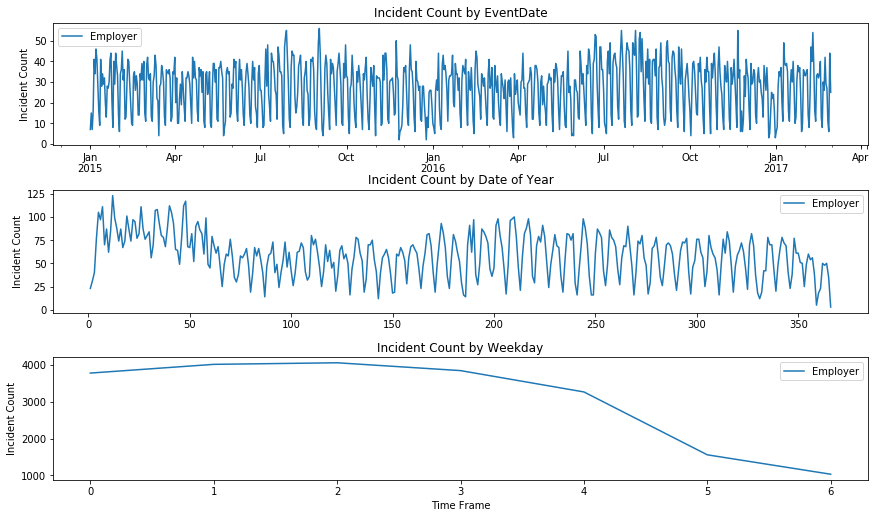

In [299]:
time_slicer(df=df,timeframes=["EventDate","Date of Year","Weekday"])

### Categorical Variables:

**Hospitalization and Amputation :(**

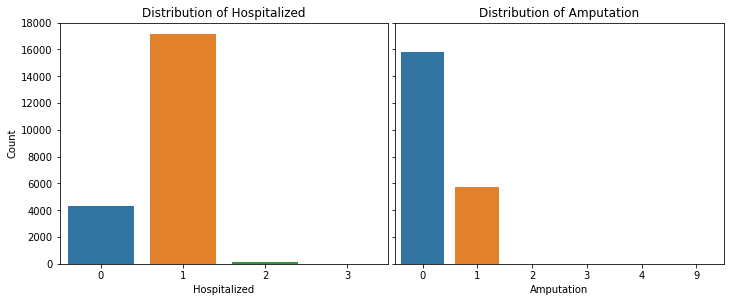

In [67]:
f, ax = plt.subplots(1,2, figsize=[10,4],sharey=True)
sns.countplot(df["Hospitalized"],ax=ax[0])
ax[0].set_title("Distribution of Hospitalized")
ax[0].set_ylabel("Count")
sns.countplot(df["Amputation"],ax=ax[1])
ax[1].set_title("Distribution of Amputation")
ax[1].set_ylabel("")
plt.tight_layout(pad=0)

**Employer, City, and State:** <br>

In [41]:
def cat_countplot(df, var, size = [8,10], n=15):
    """
    Function to plot multiple seaborn count plots horizontally, and ordered by most frequent class.
    """
    f, ax = plt.subplots(len(var),figsize=size)
    for i,x in enumerate(var):
        temptop = df[x].value_counts().index[:n]
        sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax[i])
        ax[i].set_title("Distribution of {}".format(x))
        ax[i].set_xlabel("")
    ax[len(var)-1].set_xlabel("Count")
    plt.tight_layout(pad=0)

def continous_plots(df, var):
    # Continous Distributions
    f, ax = plt.subplots(1,len(var),figsize=(12,4), sharey=False)
    for i,x in enumerate(var):
        sns.distplot(df[x], ax=ax[i])
        ax[i].set_title("{} Distribution".format(x))
        ax[i].set_ylabel("")
        ax[i].set_xlabel("Distribution")
    ax[0].set_ylabel("Density")
    plt.tight_layout()

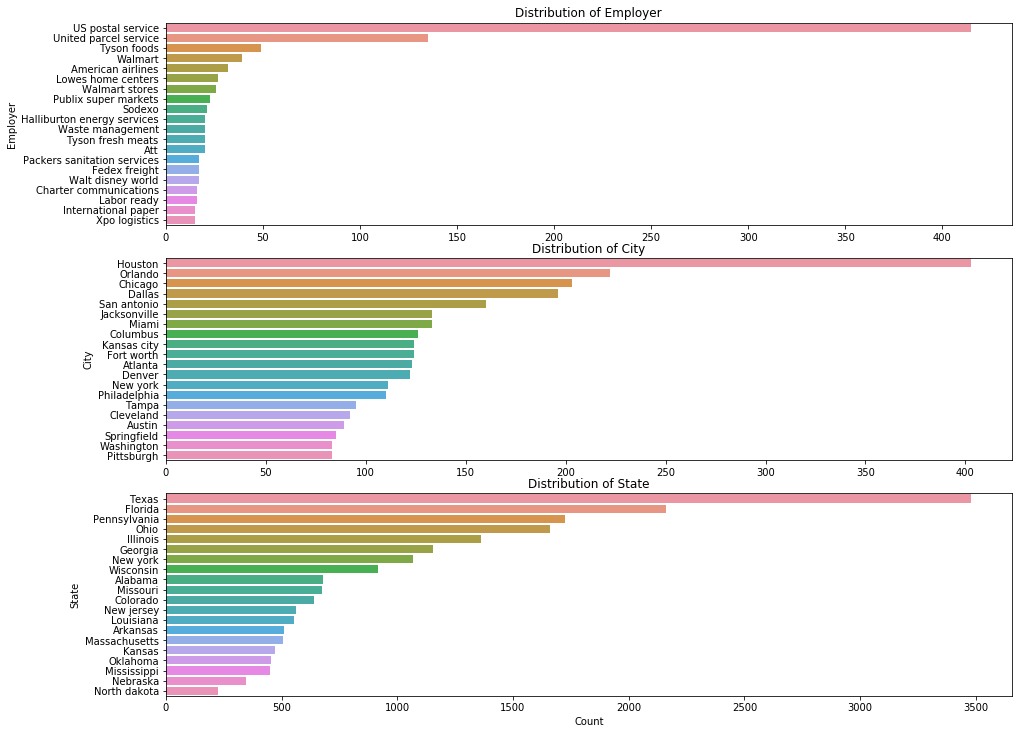

In [289]:
cat_countplot(df=df, var=["Employer","City","State"],n=20, size=[14,10])

**NatureTitle and Source Title:** <br>

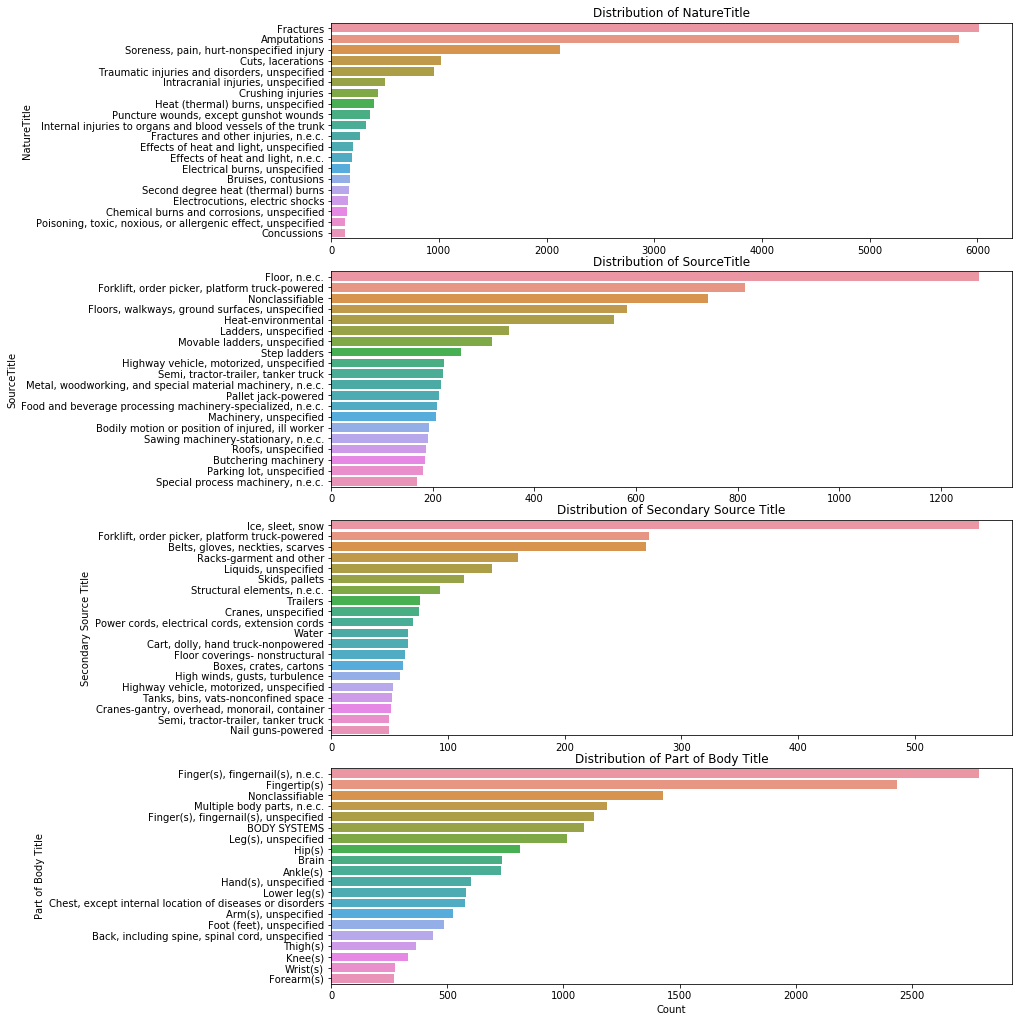

In [77]:
cat_countplot(df=df, var=["NatureTitle","SourceTitle","Secondary Source Title","Part of Body Title"],n=20,size=[14,14])

**Event Title:** <br>

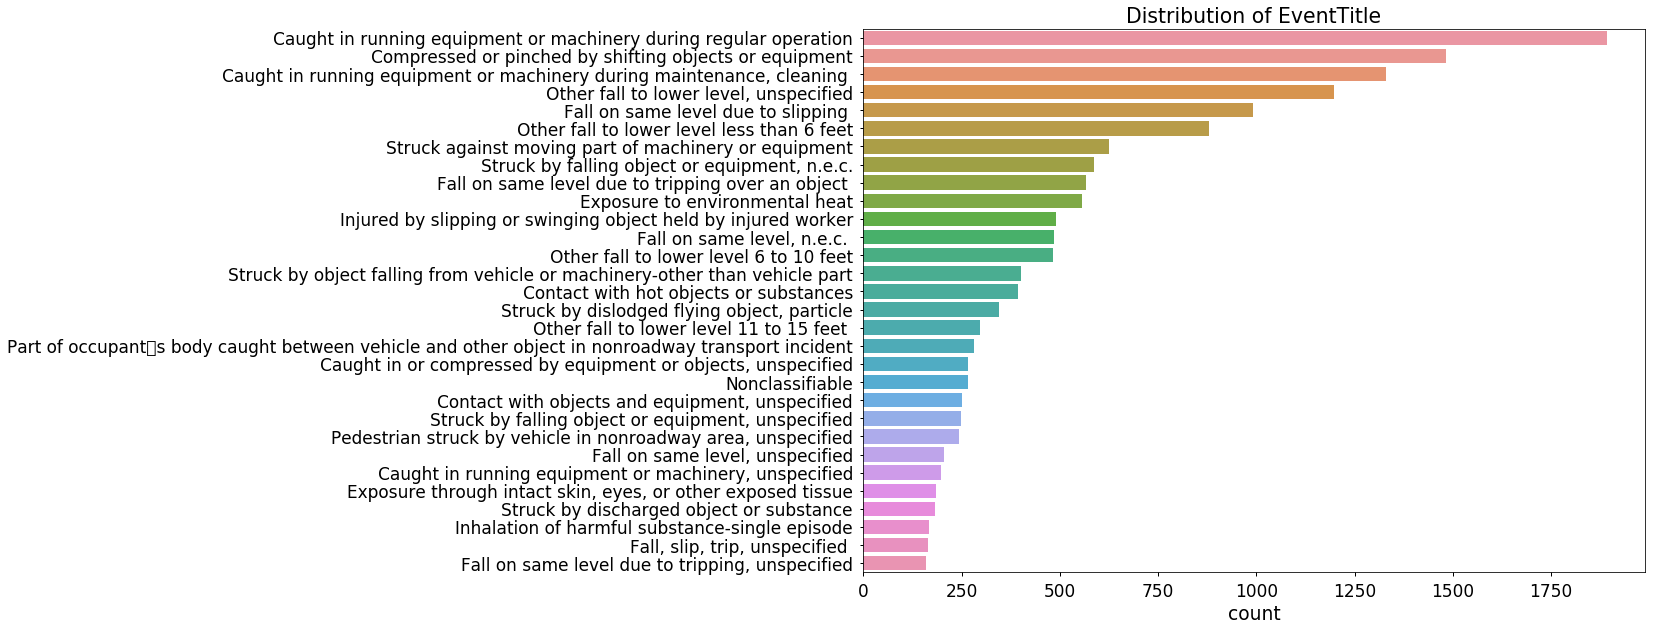

In [94]:
with sns.plotting_context("notebook", font_scale=1.7):
    f, ax = plt.subplots(1,figsize=[14,10])
    x= "EventTitle"
    n=30
    temptop = df[x].value_counts().index[:n]

    sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax)
    ax.set_title("Distribution of {}".format(x))
    ax.set_ylabel("")
plt.show()

## Multivariate

In [310]:
# Fast funcdtion for top occruence categories
def topcat_index(series, n=5):
    return series.value_counts().index[:n]
def topcats(series, n=5):
    return series.isin(topcat_index(series, n=n))
        #series.value_counts().index[:n])

## New Amputation Variable
df["Amputated"]= False
df.loc[df["Amputation"] > 0,"Amputated"] = True
print(df["Amputated"].value_counts())

False    15791
True      5787
Name: Amputated, dtype: int64


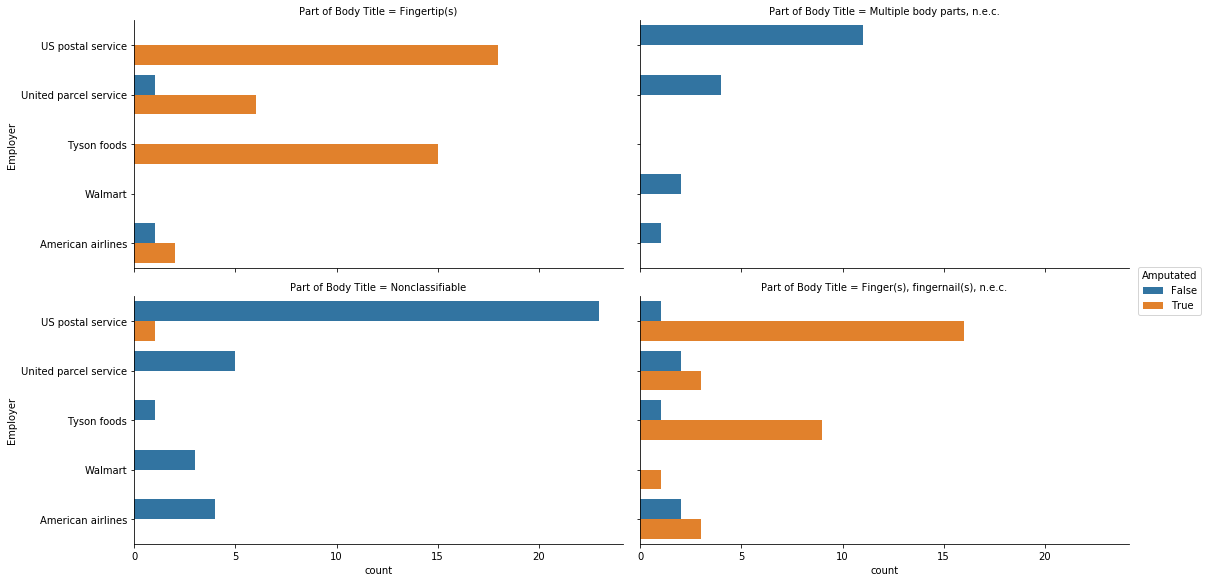

In [401]:
col = "Part of Body Title"
temp = df.loc[(topcats(df["Employer"]))
              &(topcats(df[col],n=4))
              ,:]
sns.factorplot(y="Employer", hue="Amputated", col=col, col_wrap=2,
            data=temp, kind="count",
               order=df["Employer"].value_counts().index[:5],aspect=2)
plt.show()

Makes me wonder which accidents lead to the most amputations.

**Times Series:** <Br>

In [364]:
def cat_time_slicer(df, slicevar, n, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,7])
    top_classes = topcat_index(df[slicevar],n=n)
    for i,x in enumerate(timeframes):
        for y in top_classes:
            total = df.loc[df[slicevar]==y,slicevar].count()
            ((df.loc[(df[slicevar]==y),[x,"Employer"]]
             .groupby([x])
             .count()/total)
            .plot(ax=ax[i], label=y))
        ax[i].set_ylabel("Percent of\nCompany Incidents")
        ax[i].set_title("Percent of Incident by Company by {}".format(x))
        ax[i].set_xlabel("")
        ax[i].legend(top_classes, fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle('Normalized Time-Series for top {} {}s over different over {}'.format(n,slicevar,timeframes),fontsize=17)

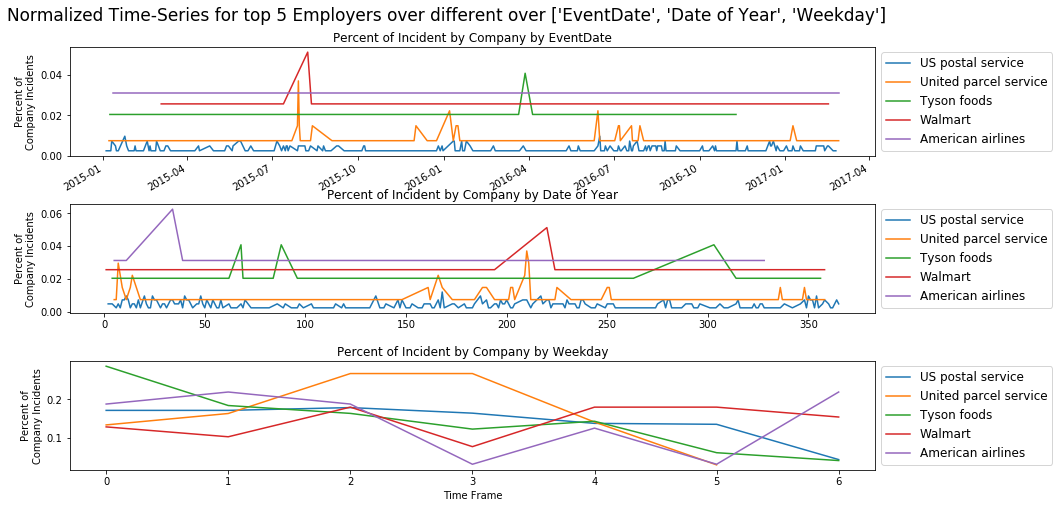

In [366]:
cat_time_slicer(df=df, slicevar = "Employer",
                n=5, timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
Mondays are the most dangerous at the US Postal Service, and Wednesday are the most dangerous for United Parel Service.

Also, US Postal's accidents are frequent, while other companies less so.

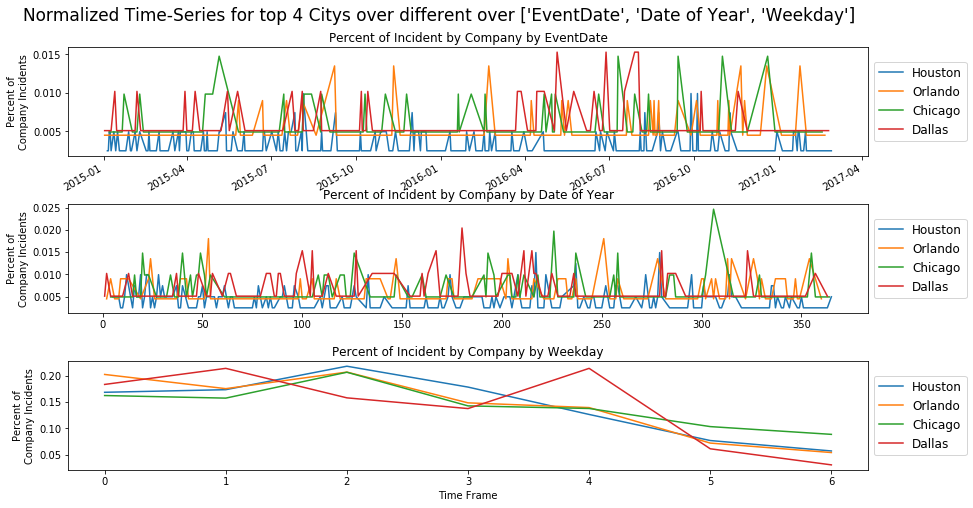

In [367]:
cat_time_slicer(df=df, slicevar = "City",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

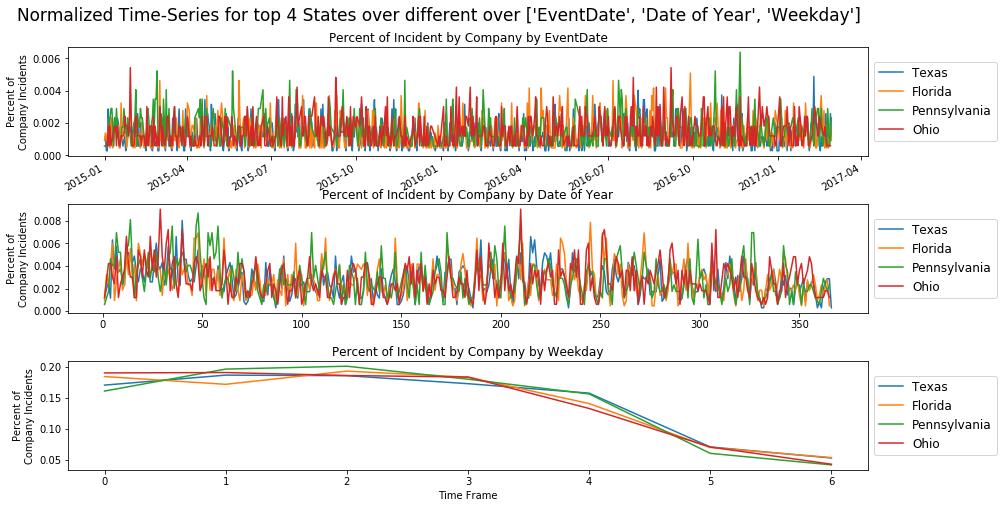

In [368]:
cat_time_slicer(df=df, slicevar = "State",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

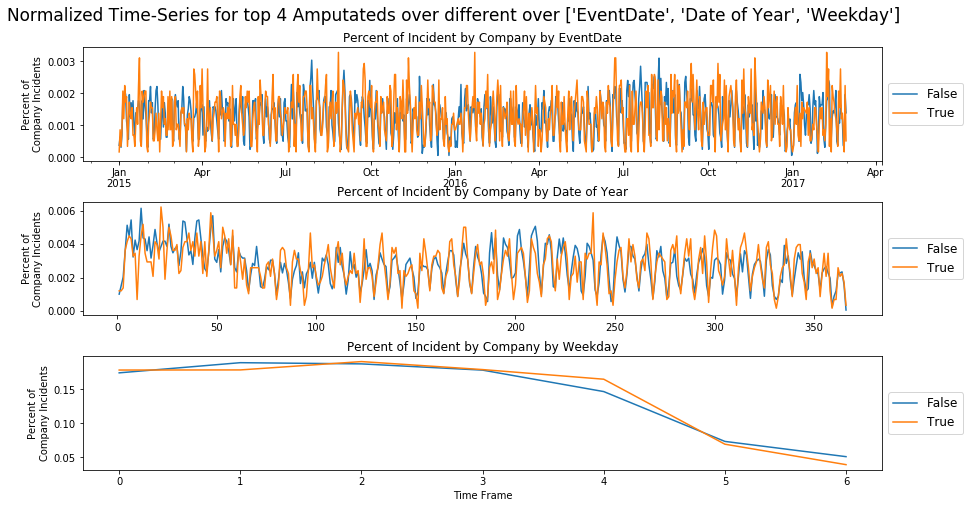

In [369]:
cat_time_slicer(df=df, slicevar = "Amputated",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

## Some Horrible Reports - BEWARE

In [410]:
[print("{}\n".format(x)) for x in 
 df["Final Narrative"].loc[
     (df["Amputated"]==True) & 
     (df["Final Narrative"]
      .str.contains(r"(?i)gun|(?i)burn|(?i)shock"))]
 .sample(10)]

An employee was working with a perforating gun on a work bench. He turned the gun and it skipped off the roller wheels and fell on the edge of the table, amputating the index and middle fingertips on his right hand.

On December 7, 2015, an employee received an electrical shock when the steel cables attached to the spider basket in which the employee was working contacted an overhead power line. The employee suffered electrical burns to the right hand and stomach and the amputation of his right arm just below the elbow.

An employee received an electrical shock while repairing 7200 KV power lines resulting in hospitalization and the amputation of three fingers on his left hand.

1. On 11/1/15, an employee was changing the reel of paper and caught the left middle finger in a nip point. The finger was amputated to the first knuckle.


2. On 11/11/15, an employee received chemical and thermal burns to the right hand and knee from caustic hydrogen peroxide due to an unclosed valve on the p

[None, None, None, None, None, None, None, None, None, None]

***
Lots of crazy line plots as usual. Few more things I want to investigate, such as what injury type leads to the most amputations, and which company has the most amputations, scaled of course.

These accidents are making my stomach churn. Im out.

_-Nick_

## TO DO

find "HER" and "HE" in narrative